# 4.6 Pitch Attidute and Altitude Hold Autopilots

#### Examples 4.6-1 through 4.6-3

In [10]:
import sys
sys.path.append('../')
from lin_transport import get_lin_transport
import control as ct
import numpy as np
import matplotlib.pyplot as plt

In [11]:
RTOD = 57.296
# Constants
Vt = 500  # ft/s
alpha = 2.0/RTOD  # rad
theta = 2.0/RTOD  # rad
altitude = 25e3  # ft
x_Earth = 0  # ft
X0 = [Vt, alpha, theta, 0, altitude, x_Earth]
thtl = 0.2  # throttle 0-1
elev = -2.0  # deg
U0 = [thtl, elev]

sys = get_lin_transport(X0, U0, theta - alpha)

[ 0.0725267   0.20438501 -2.38215508]
Trim results:
Cost = 1.0962256112451988e-11
Keas (knots): 198.86
Alpha (deg): 4.16
Theta (deg): 4.16
Throttle (0-1): 0.20
Elevator (deg): -2.38


In [12]:
ap = sys.A[0:5,0:5]
bp = sys.B[0:5,[1]]
cp = sys.C[0:5,0:5][[2,3]]
dp = sys.D[[2,3]][:,[1]]
plant = ct.ss(ap, bp, cp, dp)
plant

<LinearIOSystem:sys[20]:['u[0]']->['y[0]', 'y[1]']>

In [13]:
sysa = ct.ss([-10], [10], [-1], [0]) # actuator (change sign for elev up positive)
sys1 = ct.series(sysa, plant)
sys1_tf = ct.ss2tf(ct.ss(sys1.A, sys1.B, sys1.C[[0]], sys1.D[[0]]))

zeros = ct.zero(sys1_tf)
poles = ct.pole(sys1_tf)

print("Closed Loop Zeros:", zeros)
print("Closed Loop Poles:", poles)
print(sys1_tf)

Closed Loop Zeros: [ 3.79237827e-02+39938857.7660074j  3.79237827e-02-39938857.7660074j
 -1.62676979e-04       +0.j        -1.90216221e-02       +0.j
 -5.56663266e-01       +0.j       ]
Closed Loop Poles: [-1.00000000e+01+0.j         -5.23360199e-01+1.21742819j
 -5.23360199e-01-1.21742819j -2.46640595e-03+0.09007424j
 -2.46640595e-03-0.09007424j -1.84462701e-04+0.j        ]

7.105e-15 s^5 + 3.553e-15 s^4 + 11.33 s^3 + 6.527 s^2 + 0.1211 s + 1.952e-05
----------------------------------------------------------------------------
 s^6 + 11.05 s^5 + 12.29 s^4 + 17.71 s^3 + 0.1891 s^2 + 0.1426 s + 2.63e-05



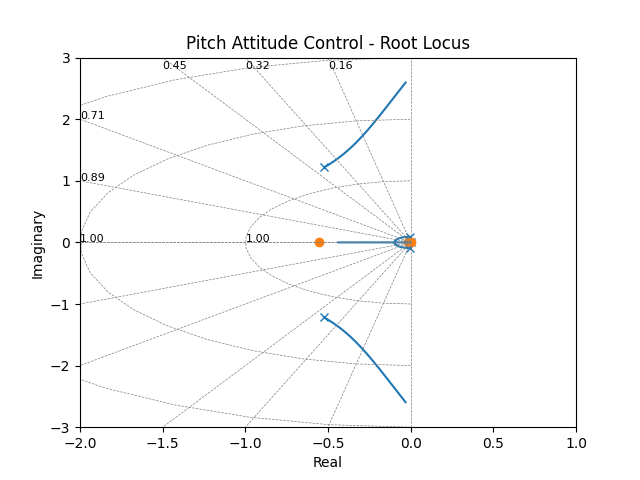

In [14]:
%matplotlib widget
plt.figure()
ct.root_locus(sys1_tf,kvect=np.linspace(0,5,500), xlim=[-2, 1], ylim=[-3, 3])
plt.title('Pitch Attitude Control - Root Locus')
plt.show()

In [15]:
k_theta = 4.0
acl = sys1.A - sys1.B @ np.array([[k_theta, 0]]) @ sys1.C
sys2 = ct.ss(acl, sys1.B, sys1.C, sys1.D)
ct.ss2tf(sys2[1,0])

TransferFunction(array([-3.01980663e-14,  1.13339550e+01,  6.52663039e+00,  1.21072582e-01,
        1.95230513e-05,  2.71050543e-20]), array([1.00000000e+00, 1.10518377e+01, 1.22878907e+01, 6.30484474e+01,
       2.62956565e+01, 6.26905205e-01, 1.04393006e-04]))

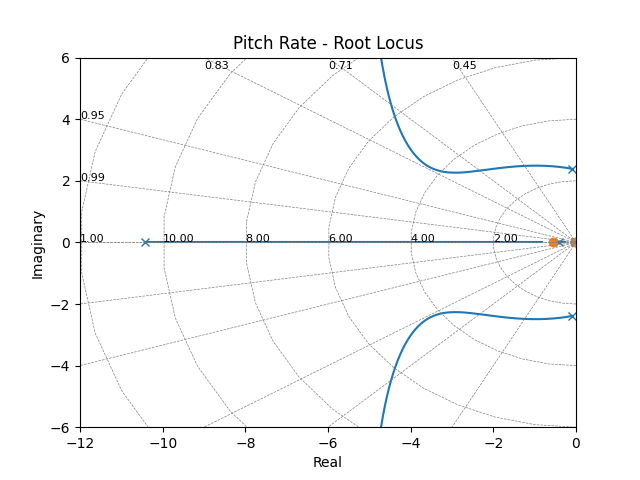

In [16]:
sys2_tf = ct.ss2tf(ct.ss(sys2.A, sys2.B, sys2.C[[1]], 0))
plt.figure()
ct.root_locus(sys2_tf,kvect=np.linspace(0,10,500), xlim=[-12, 0], ylim=[-6, 6])
plt.title('Pitch Rate - Root Locus')
plt.show()

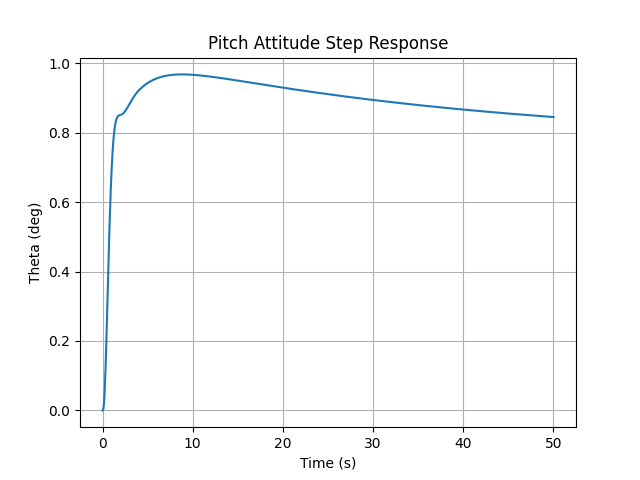

In [17]:
k_q = 2.5
acl = sys1.A - sys1.B @ np.array([[0, k_q]]) @ sys1.C
sys_theta = ct.ss(acl, sys1.B, sys1.C[[0]], sys1.D[[0]])
acl2 = sys_theta.A - sys_theta.B @ np.array([[k_theta]]) @ sys_theta.C
sys_final = ct.ss(acl2, sys_theta.B * k_theta, sys_theta.C, sys_theta.D)
plt.figure()
t, y = ct.step_response(sys_final, T=np.linspace(0,50,1000))
plt.plot(t, y.T)
plt.title('Pitch Attitude Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Theta (deg)')
plt.grid()
plt.show()

In [18]:
print(f"DC Gain: {ct.dcgain(sys_final[0,0]):.2f}")

DC Gain: 0.75
